### Objective: Time Series Regression for Power Consumption Forecasting

This project implements time series regression techniques for forecasting <br>
power consumption using three different models: **SARIMAX**, **XGBoost**, and **LSTM** <br>

The workflow includes data preprocessing, model training, hyperparameter optimization, <br>
 evaluation, and visualization of the results.

### Steps
1: Data Exploration and Preprocessing <br>
2: Model Training with SARIMAX, XGBoost, and LSTM <br>
3: Evaluation Metrics and Visualization <br>
4: Deliverables <br>
<br>
<br>

1. **Data Preparation**
    - Load the household power consumption dataset.
    - Analyze seasonality and stationarity of the time series data.
    - Split the dataset into training and testing sets.

2. **Model Training**
    - Split the dataset into training and testing sets.
    - Standard Scaling ($\mu$ = 0, $\sigma$ = 1) for XGBoost and LSTM
    - Trained with SARIMAX, XGBoost (optuna), and LSTM 

3. **Evaluation**
    - Evaluate MSE, MAE, and R2
    - Visualized the prediction results

4. **Deliverables**
    - SARIMAX, and XGBoost trained models were saved to 'pkl'
    files, and LSTM to 'keras' for reproducing test results.

In [1]:
# check python vsersion
!python --version

Python 3.12.2


In [ ]:
%%writefile requirements.txt
pandas==2.2.2
numpy==1.26.4
seaborn==0.13.2
matplotlib==3.9.2
statsmodels==0.14.4
scikit-learn==1.5.2
xgboost==2.1.1
optuna==4.0.0
tensorflow==2.18.0
joblib==1.4.2

Overwriting requirements.txt


In [3]:
!pip install -r requirements.txt

In [3]:
# load module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import optuna
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras import metrics

import joblib

In [4]:
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
df = pd.read_csv(url, sep=";", na_values="?", low_memory=False)
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.drop(columns=['Date', 'Time'], inplace=True)

In [5]:
df.info

<bound method DataFrame.info of          Global_active_power  Global_reactive_power  Voltage  \
0                      4.216                  0.418   234.84   
1                      5.360                  0.436   233.63   
2                      5.374                  0.498   233.29   
3                      5.388                  0.502   233.74   
4                      3.666                  0.528   235.68   
...                      ...                    ...      ...   
2075254                0.946                  0.000   240.43   
2075255                0.944                  0.000   240.00   
2075256                0.938                  0.000   239.82   
2075257                0.934                  0.000   239.70   
2075258                0.932                  0.000   239.55   

         Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
0                    18.4             0.0             1.0            17.0   
1                    23.0             0.0    

In [6]:
# Data preprocessing
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df.dropna()
df = df[['datetime', 'Global_active_power']]
df.set_index('datetime', inplace=True)

# Resample to hourly data to reduce noise
df = df.resample('h').mean()

# Fill missing values with interpolation
df['Global_active_power'] = df['Global_active_power'].interpolate()



Interpretation:
- If the seasonal component in the decomposition plot is flat or absent, 
  it further confirms the dataset is non-seasonal.
- If the ACF/PACF plots do not show repeating patterns at regular intervals, 
  then the dataset is likely non-seasonal.
- The ADF test checks if the series has a unit root. A p-value > 0.05 
  indicates the series is non-stationary, but this does not directly imply seasonality.



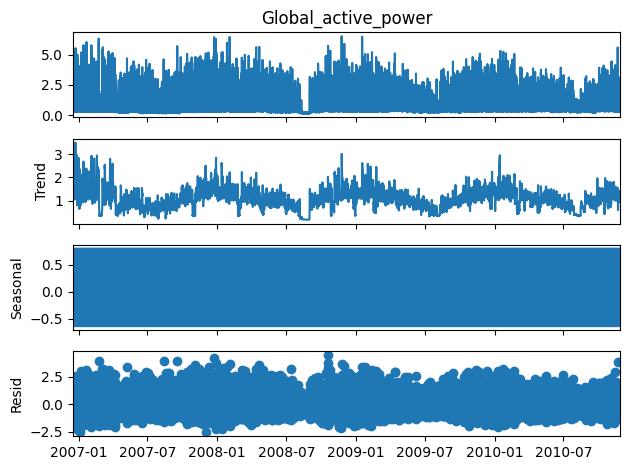

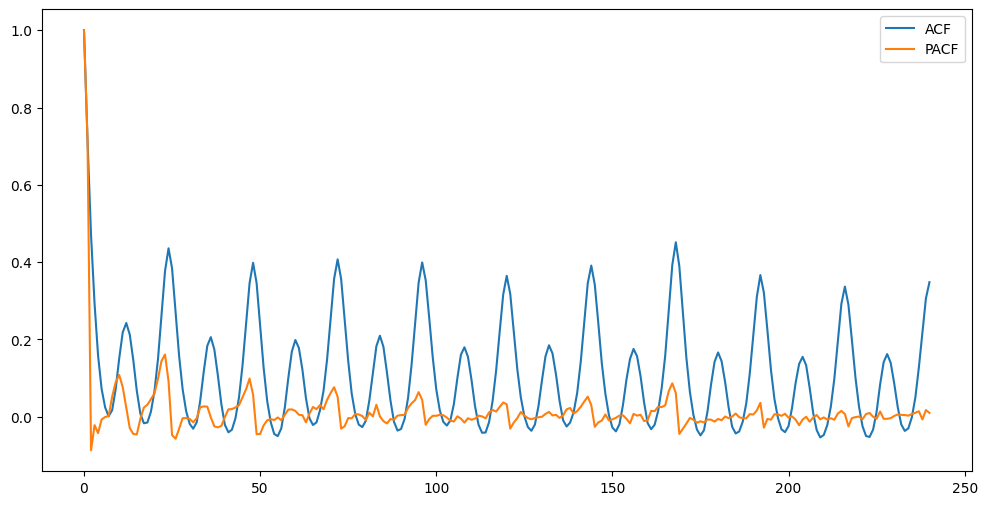

ADF Statistic: -14.382566338396966
P-value: 9.101197279691604e-27


In [10]:
print("""
Interpretation:
- If the seasonal component in the decomposition plot is flat or absent, 
  it further confirms the dataset is non-seasonal.
- If the ACF/PACF plots do not show repeating patterns at regular intervals, 
  then the dataset is likely non-seasonal.
- The ADF test checks if the series has a unit root. A p-value > 0.05 
  indicates the series is non-stationary, but this does not directly imply seasonality.
""")

# Check for non-seasonality using ACF/PACF and seasonal decomposition
result = seasonal_decompose(df['Global_active_power'], model='additive', period=24, extrapolate_trend='freq')
result.plot()
plt.show()

# ACF and PACF plots
plt.figure(figsize=(12, 6))
sns.lineplot(x=range(len(acf(df['Global_active_power'].dropna(), nlags=240))), y=acf(df['Global_active_power'].dropna(), nlags=240), label='ACF')
sns.lineplot(x=range(len(pacf(df['Global_active_power'].dropna(), nlags=240))), y=pacf(df['Global_active_power'].dropna(), nlags=240), label='PACF')
plt.legend()
plt.show()

# ADF Test
adf_test = adfuller(df['Global_active_power'].dropna())
print(f"ADF Statistic: {adf_test[0]}\nP-value: {adf_test[1]}")

In [11]:
# Preperation for Data Modelings

# Data split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

#### Data modelings: SARIMAX, Xgboost (optuna), LSTM 

In [12]:
# Prepare data for SARIMA
sarima_model = SARIMAX(train['Global_active_power'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
sarima_result = sarima_model.fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04241D+00    |proj g|=  4.80459D-01


 This problem is unconstrained.



At iterate    5    f=  9.40978D-01    |proj g|=  7.48848D-02

At iterate   10    f=  8.83725D-01    |proj g|=  3.98375D-02

At iterate   15    f=  8.79468D-01    |proj g|=  1.15494D-02

At iterate   20    f=  8.77000D-01    |proj g|=  5.25584D-02

At iterate   25    f=  8.74384D-01    |proj g|=  3.89592D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     38      1     0     0   5.866D-06   8.744D-01
  F =  0.87437051662670962     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [13]:
# XGB and LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [14]:

# Prepare data for XGBoost
look_back = 24

def create_features(dataset, look_back):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i - look_back:i])
        y.append(dataset[i])
    return np.array(X), np.array(y)

# Scale data for XGBoost and LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['Global_active_power'].values.reshape(-1, 1))

X, y = create_features(scaled_data, look_back)
X_train_xgb, X_test_xgb = X[:train_size - look_back], X[train_size - look_back:]
y_train_xgb, y_test_xgb = y[:train_size - look_back], y[train_size - look_back:]

# Reshape XGBoost data
X_train_xgb = X_train_xgb.reshape((X_train_xgb.shape[0], X_train_xgb.shape[1]))
X_test_xgb = X_test_xgb.reshape((X_test_xgb.shape[0], X_test_xgb.shape[1]))

# Optuna objective function
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    xgb_model = XGBRegressor(**param)
    xgb_model.fit(X_train_xgb, y_train_xgb)
    preds = xgb_model.predict(X_test_xgb)
    return mean_squared_error(y_test_xgb, preds)

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print("Best XGBoost parameters:", study.best_params)

# Train final XGBoost model
best_params = study.best_params
xgb_model = XGBRegressor(**best_params)
xgb_model.fit(X_train_xgb, y_train_xgb)

[I 2024-12-01 07:27:40,386] A new study created in memory with name: no-name-d9422cc8-80f1-418c-a8e2-43261780425f


[I 2024-12-01 07:27:42,637] Trial 0 finished with value: 0.0064410397965662435 and parameters: {'n_estimators': 261, 'max_depth': 8, 'learning_rate': 0.2702167733657122, 'subsample': 0.9818403133660085, 'colsample_bytree': 0.7742787176235012}. Best is trial 0 with value: 0.0064410397965662435.
[I 2024-12-01 07:27:43,916] Trial 1 finished with value: 0.005668346785754074 and parameters: {'n_estimators': 497, 'max_depth': 6, 'learning_rate': 0.029252133396894094, 'subsample': 0.7183220282469419, 'colsample_bytree': 0.6204155933602314}. Best is trial 1 with value: 0.005668346785754074.
[I 2024-12-01 07:27:44,733] Trial 2 finished with value: 0.006857420369278367 and parameters: {'n_estimators': 286, 'max_depth': 6, 'learning_rate': 0.27857901698466275, 'subsample': 0.5618311480042626, 'colsample_bytree': 0.898129156857841}. Best is trial 1 with value: 0.005668346785754074.
[I 2024-12-01 07:27:45,122] Trial 3 finished with value: 0.005903925517534178 and parameters: {'n_estimators': 333, '

Best XGBoost parameters: {'n_estimators': 466, 'max_depth': 10, 'learning_rate': 0.01086871492197956, 'subsample': 0.9626526254290244, 'colsample_bytree': 0.6308825437093947}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6308825437093947, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01086871492197956, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=466, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
# Prepare data for LSTM
X, y = [], []
look_back = 24
for i in range(len(scaled_data) - look_back):
    X.append(scaled_data[i:i + look_back])
    y.append(scaled_data[i + look_back])

X, y = np.array(X), np.array(y)
X_train_lstm, X_test_lstm = X[:train_size - look_back], X[train_size - look_back:]
y_train_lstm, y_test_lstm = y[:train_size - look_back], y[train_size - look_back:]

lstm_model = Sequential([
    Input(shape=(look_back, 1)),  # Use an explicit Input layer here.
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

#lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.compile(optimizer='adam', loss='mse', metrics=[metrics.MeanSquaredError()])
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))


Epoch 1/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_lo

In [29]:
# Define the number of periods to predict
seasonal_period = 24  # One day for hourly data
forecast_horizon = 100 * seasonal_period  # 100 full periods

# SARIMA prediction
y_pred_sarima = sarima_result.forecast(steps=forecast_horizon)

# XGB prediction
y_pred_xgb = xgb_model.predict(X_test_xgb[:forecast_horizon])
y_pred_xgb = scaler.inverse_transform(y_pred_xgb.reshape(-1, 1))


# LSTM prediction
y_pred_lstm = lstm_model.predict(X_test_lstm[:forecast_horizon])
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


SARIMA MSE: 0.6296495477346858, MAE: 0.5980413857104919, R2: -0.061403540698407255
XGBoost MSE: 0.2652751986074542, MAE: 0.35793435484035657, R2: 0.5528242082053124
LSTM MSE: 0.2898049975964893, MAE: 0.36757571068143363, R2: 0.5114741975632769


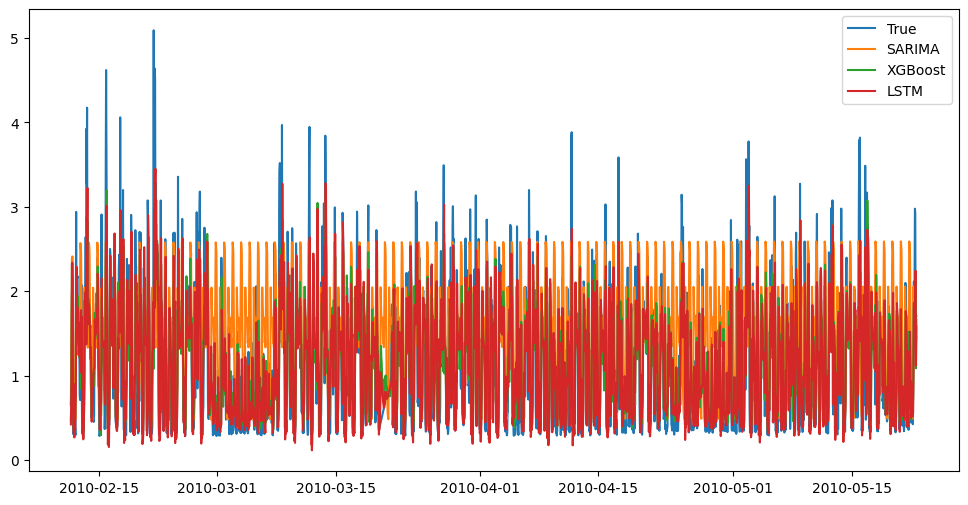

In [30]:
# Evaluation
mse_sarima = mean_squared_error(test['Global_active_power'][:forecast_horizon], y_pred_sarima)
mse_xgb = mean_squared_error(test['Global_active_power'][:forecast_horizon], y_pred_xgb)
mse_lstm = mean_squared_error(test['Global_active_power'][:forecast_horizon], y_pred_lstm.flatten())

mae_sarima = mean_absolute_error(test['Global_active_power'][:forecast_horizon], y_pred_sarima)
mae_xgb = mean_absolute_error(test['Global_active_power'][:forecast_horizon], y_pred_xgb)
mae_lstm = mean_absolute_error(test['Global_active_power'][:forecast_horizon], y_pred_lstm.flatten())

r2_sarima = r2_score(test['Global_active_power'][:forecast_horizon], y_pred_sarima)
r2_xgb = r2_score(test['Global_active_power'][:forecast_horizon], y_pred_xgb)
r2_lstm = r2_score(test['Global_active_power'][:forecast_horizon], y_pred_lstm.flatten())

print(f"SARIMA MSE: {mse_sarima}, MAE: {mae_sarima}, R2: {r2_sarima}")
print(f"XGBoost MSE: {mse_xgb}, MAE: {mae_xgb}, R2: {r2_xgb}")
print(f"LSTM MSE: {mse_lstm}, MAE: {mae_lstm}, R2: {r2_lstm}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index[:forecast_horizon], test['Global_active_power'][:forecast_horizon], label='True')
plt.plot(test.index[:forecast_horizon], y_pred_sarima, label='SARIMA')
plt.plot(test.index[:forecast_horizon], y_pred_xgb, label='XGBoost')
plt.plot(test.index[:forecast_horizon], y_pred_lstm.flatten(), label='LSTM')
plt.legend()
plt.show()



In [18]:
# Save models

# Save SARIMA model 
joblib.dump(sarima_result, 'sarima_model.pkl')

# Save the XGBoost model
joblib.dump(xgb_model, 'xgb_model.pkl')

## Save LSTM model
lstm_model.save('lstm_model.keras')

# Now, to load and reproduce the results

# Load the SARIMA model
sarima_result_loaded = joblib.load('sarima_model.pkl')

# Load the XGBoost model
xgb_model_loaded = joblib.load('xgb_model.pkl')

# Load the LSTM model
lstm_model_loaded = load_model('lstm_model.keras')


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Loaded SARIMA MSE: 0.6296495477346858, MAE: 0.5980413857104919, R2: -0.061403540698407255
Loaded XGBoost MSE: 0.2652751986074542, MAE: 0.35793435484035657, R2: 0.5528242082053124
Loaded LSTM MSE: 0.2898049975964893, MAE: 0.36757571068143363, R2: 0.5114741975632769


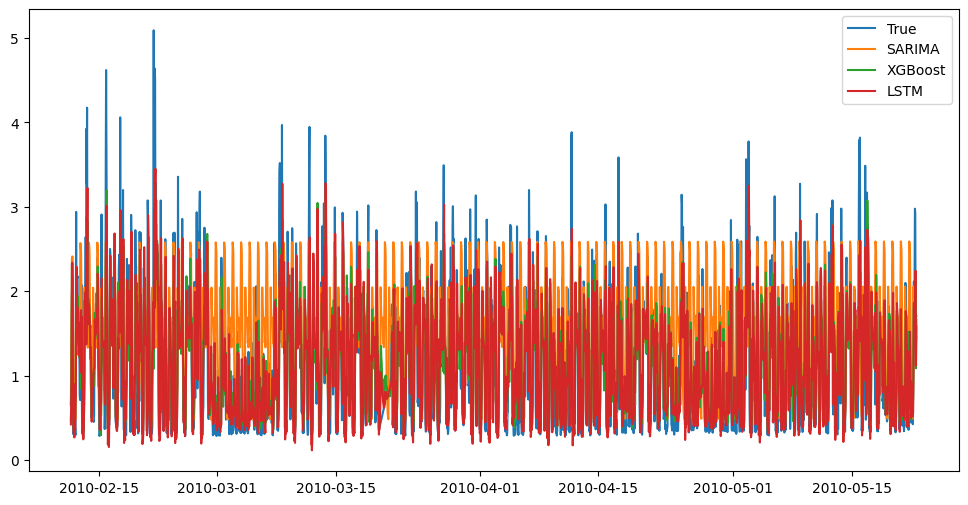

In [19]:
# Reproduce predictions using the loaded models

# SARIMA predictions (forecasting for 100 periods)
predictions_sarima_loaded = sarima_result_loaded.forecast(steps=forecast_horizon)

# XGBoost predictions (forecasting for 100 periods)
predictions_xgb_loaded = xgb_model.predict(X_test_xgb[:forecast_horizon])
predictions_xgb_loaded = scaler.inverse_transform(predictions_xgb_loaded.reshape(-1, 1))

# LSTM predictions (forecasting for 100 periods)
predictions_lstm_loaded = lstm_model_loaded.predict(X_test_lstm[:forecast_horizon])
predictions_lstm_loaded = scaler.inverse_transform(predictions_lstm_loaded)


# Evaluation of the loaded models
mse_sarima_loaded = mean_squared_error(test['Global_active_power'][:forecast_horizon], predictions_sarima_loaded)
mse_xgb_loaded = mean_squared_error(test['Global_active_power'][:forecast_horizon], predictions_xgb_loaded)
mse_lstm_loaded = mean_squared_error(test['Global_active_power'][:forecast_horizon], predictions_lstm_loaded.flatten())

mae_sarima_loaded = mean_absolute_error(test['Global_active_power'][:forecast_horizon], predictions_sarima_loaded)
mae_xgb_loaded = mean_absolute_error(test['Global_active_power'][:forecast_horizon], predictions_xgb_loaded)
mae_lstm_loaded = mean_absolute_error(test['Global_active_power'][:forecast_horizon], predictions_lstm_loaded.flatten())

r2_sarima_loaded = r2_score(test['Global_active_power'][:forecast_horizon], predictions_sarima_loaded)
r2_xgb_loaded = r2_score(test['Global_active_power'][:forecast_horizon], predictions_xgb_loaded)
r2_lstm_loaded = r2_score(test['Global_active_power'][:forecast_horizon], predictions_lstm_loaded.flatten())

# Print results for loaded models
print(f"Loaded SARIMA MSE: {mse_sarima_loaded}, MAE: {mae_sarima_loaded}, R2: {r2_sarima_loaded}")
print(f"Loaded XGBoost MSE: {mse_xgb_loaded}, MAE: {mae_xgb_loaded}, R2: {r2_xgb_loaded}")
print(f"Loaded LSTM MSE: {mse_lstm_loaded}, MAE: {mae_lstm_loaded}, R2: {r2_lstm_loaded}")

# Plot results for loaded models
plt.figure(figsize=(12, 6))
plt.plot(test.index[:forecast_horizon], test['Global_active_power'][:forecast_horizon], label='True')
plt.plot(test.index[:forecast_horizon], predictions_sarima_loaded, label='SARIMA')
plt.plot(test.index[:forecast_horizon], predictions_xgb_loaded, label='XGBoost')
plt.plot(test.index[:forecast_horizon], predictions_lstm_loaded.flatten(), label='LSTM')
plt.legend()
plt.show()